## Importing Required Libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import os
import random
import keras

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report
import tensorflow as tf

## Extracting Files

In [2]:
c = 'E:\\VIT\\sem_4-2\\Health care\\project\\COVID-19_Radiography_Dataset\\COVID\\images'
n = 'E:\\VIT\\sem_4-2\\Health care\\project\\COVID-19_Radiography_Dataset\\Normal\\images'
p = 'E:\\VIT\\sem_4-2\\Health care\\project\\COVID-19_Radiography_Dataset\\Viral Pneumonia\\images'

In [3]:
random.seed(42)
filenames = os.listdir(c) + random.sample(os.listdir(n), 2500) + os.listdir(p)

### Classes
* 0 -> Normal
* 1 -> Viral Pneumonia
* 2 -> COVID

In [4]:
categories = []
for filename in filenames:
    category = filename.split('-')[0]
    if category == 'COVID':
        categories.append(str(2))
    elif category == 'Viral Pneumonia':
        categories.append(str(1))
    else:
        categories.append(str(0))

## Converting to Dataframe

In [5]:
for i in range(len(filenames)):
    if 'COVID' in filenames[i]:
        filenames[i] = os.path.join(c, filenames[i])
    elif 'Viral Pneumonia' in filenames[i]:
        filenames[i] = os.path.join(p, filenames[i])
    else:
        filenames[i] = os.path.join(n, filenames[i])
    
    
df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [6]:
df.head()

,filename,category
0,../input/covid19-radiography-database/COVID-19...,2
1,../input/covid19-radiography-database/COVID-19...,2
2,../input/covid19-radiography-database/COVID-19...,2
3,../input/covid19-radiography-database/COVID-19...,2
4,../input/covid19-radiography-database/COVID-19...,2


In [7]:
df.shape

(7461, 2)

## Exploratory Data Analysis

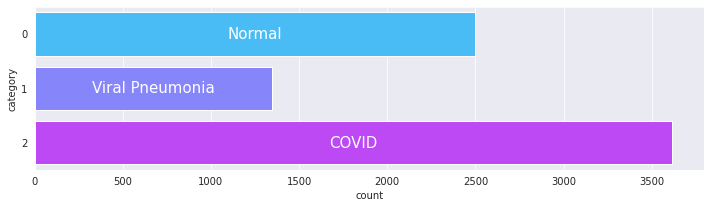

In [8]:
plt.figure(figsize=(12,3))
splot = sns.countplot(data = df.sort_values(by='category'), y ='category', palette='cool', saturation=0.9)
plt.bar_label(container=splot.containers[0], 
              labels=['Normal', 'Viral Pneumonia', 'COVID'], 
              label_type='center', size=15, color='w')
plt.show()

## Data Visualization

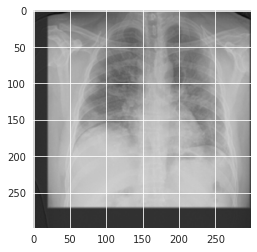

In [9]:
sample = random.choice(df['filename'])
image = load_img(sample)
plt.imshow(image)
plt.show()

## Splitting Train, Validation & Test Data

In [10]:
train_data, test_valid_data = train_test_split(df, test_size=0.2, random_state = 42, shuffle=True, stratify=df['category'])
train_data = train_data.reset_index(drop=True)
test_valid_data = test_valid_data.reset_index(drop=True)

In [11]:
test_data, valid_data = train_test_split(test_valid_data, test_size=0.5, random_state = 42,
                                         shuffle=True, stratify=test_valid_data['category'])
test_data = test_data.reset_index(drop=True)
valid_data = valid_data.reset_index(drop=True)

## Data Augmentation

In [12]:
train_data_gen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

In [13]:
train_generator = train_data_gen.flow_from_dataframe(
    train_data, 
    x_col='filename',
    y_col='category',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=32
)

Found 5968 validated image filenames belonging to 3 classes.


In [14]:
valid_data_gen = ImageDataGenerator(rescale=1./255)

valid_generator = valid_data_gen.flow_from_dataframe(
    valid_data, 
    x_col='filename',
    y_col='category',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=32
)

Found 747 validated image filenames belonging to 3 classes.


## Model Training - Xception

#### Model Architecture

In [15]:
engine = tf.keras.applications.Xception(
        # Freezing the weights of the top layer in the InceptionResNetV2 pre-traiined model
        include_top = False,

        # Use Imagenet weights
        weights = 'imagenet',

        # Define input shape to 224x224x3
        input_shape = (224 , 224 , 3),

    )
    
x = tf.keras.layers.GlobalAveragePooling2D(name = 'avg_pool')(engine.output)
x =tf.keras.layers.Dropout(0.75)(x)
x = tf.keras.layers.BatchNormalization(
                      axis=-1,
                      momentum=0.99,
                      epsilon=0.01,
                      center=True,
                      scale=True,
                      beta_initializer="zeros",
                      gamma_initializer="ones",
                      moving_mean_initializer="zeros",
                      moving_variance_initializer="ones",
                  )(x)
out = tf.keras.layers.Dense(3, activation = 'softmax', name = 'dense_output')(x)


    # Build the Keras model
model = tf.keras.models.Model(inputs = engine.input, outputs = out)
    # Compile the model

model.compile(
        # Set optimizer to Adam(0.0001)
        optimizer = tf.keras.optimizers.Adam(learning_rate= 3e-4),
        #optimizer= SGD(lr=0.001, decay=1e-6, momentum=0.99, nesterov=True),
        # Set loss to binary crossentropy
        #loss = tf.keras.losses.SparseCategoricalCrossentropy(),
        loss = 'categorical_crossentropy',
        # Set metrics to accuracy
        metrics = ['accuracy']
    )


2022-09-10 10:46:17.843597: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-10 10:46:17.933885: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-10 10:46:17.935005: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-10 10:46:17.936331: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

83697664/83683744 [==============================] - 0s 0us/step


#### Model Summary

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [17]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                                            patience=2,
                                                            verbose=2,
                                                            factor=0.5,
                                                            min_lr=0.00001)
reduce_lr =  keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=3, min_lr=0.00001)

In [18]:
 history = model.fit(train_generator,
                              validation_data=valid_generator, verbose=1, epochs=500,
                       callbacks=[early_stopping, reduce_lr , learning_rate_reduction]
                        )

2022-09-10 10:46:22.989481: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/500


2022-09-10 10:46:29.066696: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


187/187 [==============================] - 134s 654ms/step - loss: 0.3435 - accuracy: 0.8725 - val_loss: 0.5054 - val_accuracy: 0.8220
Epoch 2/500
187/187 [==============================] - 103s 549ms/step - loss: 0.1642 - accuracy: 0.9424 - val_loss: 0.2255 - val_accuracy: 0.9250
Epoch 3/500
187/187 [==============================] - 105s 559ms/step - loss: 0.1153 - accuracy: 0.9593 - val_loss: 0.1452 - val_accuracy: 0.9545
Epoch 4/500
187/187 [==============================] - 105s 561ms/step - loss: 0.1042 - accuracy: 0.9643 - val_loss: 0.1184 - val_accuracy: 0.9531
Epoch 5/500
187/187 [==============================] - 104s 557ms/step - loss: 0.0888 - accuracy: 0.9720 - val_loss: 0.0895 - val_accuracy: 0.9746
Epoch 6/500
187/187 [==============================] - 104s 556ms/step - loss: 0.0829 - accuracy: 0.9725 - val_loss: 0.2253 - val_accuracy: 0.9063
Epoch 7/500
187/187 [==============================] - 106s 563ms/step - loss: 0.0676 - accuracy: 0.9780 - val_loss: 0.4176 - val_

# Final Test

In [19]:
test_set = valid_data_gen.flow_from_dataframe(
    test_data, 
    x_col='filename',
    y_col='category',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 746 validated image filenames belonging to 3 classes.


In [20]:
 model.evaluate(test_set)

24/24 [==============================] - 5s 210ms/step - loss: 0.0453 - accuracy: 0.9866


[0.0453316755592823, 0.9865951538085938]

In [21]:
prob = model.predict(test_set)
predIdxs = np.argmax(prob, axis=1) 


print('\n')
print(classification_report(test_set.labels, predIdxs,target_names = ['Normal','Viral Pneumonia', 'COVID'], digits=5))



                 precision    recall  f1-score   support

         Normal    0.98780   0.97200   0.97984       250
Viral Pneumonia    0.97794   0.99254   0.98519       134
          COVID    0.98901   0.99448   0.99174       362

       accuracy                        0.98660       746
      macro avg    0.98492   0.98634   0.98559       746
   weighted avg    0.98662   0.98660   0.98657       746



## Saving Model

In [22]:
model.save('Covid.h5')

## Plotting 
* Training & Validation Loss
* Training & Validation Loss

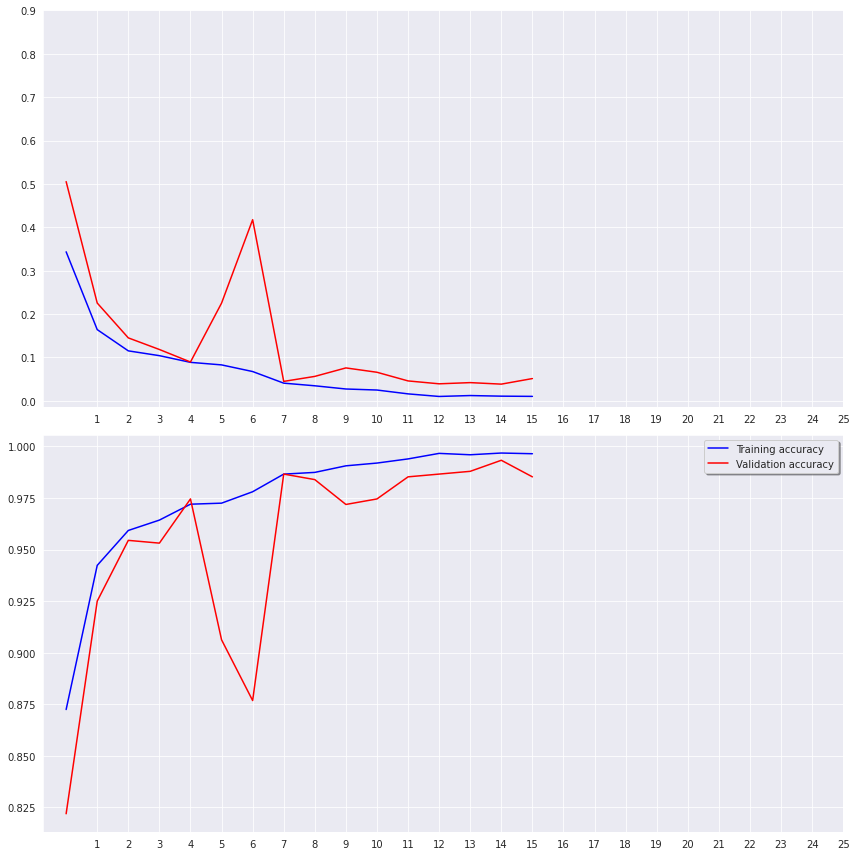

In [23]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, 26, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 26, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

## Model Testing

True value is : Normal
Prediction is:
Normal


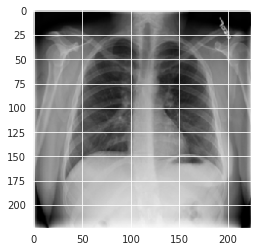

In [24]:
sample = random.choice(test_data['filename'])


category = sample.split('/')[-1].split('-')[0].upper()
true = ''
if category == 'COVID':
    true = 'COVID'
elif category == 'VIRAL PNEUMONIA':
    true = 'Viral Pneumonia'
else:
    true = 'Normal'

print(f'True value is : {true}')
    
image = load_img(sample, target_size=(224, 224))
img = img_to_array(image)/255
img = img.reshape((1, 224, 224, 3))

result = model.predict(img)
result = np.argmax(result, axis=-1)
print('Prediction is:')
if result == 0:
    print("Normal")
elif result == 1:
    print("Viral Pneumonia")
else:
    print("COVID ")
    
plt.imshow(image)

In [25]:
result

array([0])